
# Amazon Review Data 

### Bengisu Öniz
### 29.10.2019


## Introduction & Instructions

Please present your analysis and actionable insights, as if you were to present to the management of Amazon. The "Actionable business insights" should be based on data, an example of an analytical approach is as follows:

1) What is the relation between the reviews and the helpfulness?

2) What is the review behavior among different categories?

3) Is there a relationship between price and reviews?

4) Which group of reviewers is more valuable to the business?

5) Is there a relation between reviews from products which are bought together?

6) Optional - Any other hypothesis you think is interesting, as long it would have business value for Amazon


Firstly l need to write functions as l use libraries because they cannot be used in Notebook

In [78]:
import warnings
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import mlab
from scipy.stats import shapiro, normaltest
import time
import plotly.express as px
import ast
from matplotlib.pyplot import figure

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

%matplotlib inline

In [79]:
def GetMyRootFolder():
    return "C:/Users/bengisu.oniz/Documents/datasets/"


class FileReader(object):

    def __init__(self, rootPath=None):
        super().__init__()
        self.RootPath = rootPath
        if self.RootPath is None:
            self.RootPath = GetMyRootFolder()

    def ReadCsv(self, nameofthefile):
        raw = pd.read_csv(self.RootPath + nameofthefile)
        raw.rename(str.lower, axis='columns', inplace=True)
        return raw

    def ReadExcel(self, nameofthefile):
        raw = pd.read_excel(self.RootPath + nameofthefile)
        raw.rename(str.lower, axis='columns', inplace=True)
        return raw


def know_data(data):
    print('Head: {}'.format(data.ndim))
    print('Shape: {}'.format(data.shape))
    print('Length: {}'.format(data.size))
    print('Columns: {}'.format(data.columns))
    print("-----------------------------------")
    print('Types: {}'.format(data.dtypes))
    print("-----------------------------------")
    print("Nullity Check:\n", pd.isnull(data).any())

In [80]:
ta_data_root = "C:/Users/bengisu.oniz/PyProjects/Main/Cases/Takeaway/Data/"
reviews_raw_df = FileReader(ta_data_root).ReadCsv("reviews_Clothing_Shoes_and_Jewelry_5.csv")

In [81]:
ta_data_root = "C:/Users/bengisu.oniz/PyProjects/Main/Cases/Takeaway/Data/"
metadata_raw_df = FileReader(ta_data_root).ReadCsv("metadata_category_clothing_shoes_and_jewelry_only.csv")

In [82]:
metadata_raw_df.head(2)

,metadataid,asin,salesrank,imurl,categories,title,description,price,related,brand
0,2005401,B00004SR8Z,{'Clothing': 1631},http://ecx.images-amazon.com/images/I/41RfWLMD...,"[['Clothing, Shoes & Jewelry', 'Luggage & Trav...",Lewis N. Clark Deluxe Neck Stash,NaN,12.8,"{'also_bought': ['B004RJWFDU', 'B00920ZC3O', '...",Lewis N. Clark
1,2217897,B0000ZE74A,{'Clothing': 4742},http://ecx.images-amazon.com/images/I/41ryA-RO...,"[['Clothing, Shoes & Jewelry', 'Women', 'Cloth...",Vanity Fair Women's Lollipop Plus Size Cuff Le...,NaN,NaN,"{'also_bought': ['B004PEHJ6U', 'B0000TF5VK', '...",NaN


In [83]:
print("metadata",know_data(metadata_raw_df)) #getting the structure of the data

Head: 2
Shape: (23033, 10)
Length: 230330
Columns: Index(['metadataid', 'asin', 'salesrank', 'imurl', 'categories', 'title',
       'description', 'price', 'related', 'brand'],
      dtype='object')
-----------------------------------
Types: metadataid       int64
asin            object
salesrank       object
imurl           object
categories      object
title           object
description     object
price          float64
related         object
brand           object
dtype: object
-----------------------------------
Nullity Check:
 metadataid     False
asin           False
salesrank       True
imurl          False
categories     False
title           True
description     True
price           True
related         True
brand           True
dtype: bool
metadata None


In [84]:
print("reviews",know_data(reviews_raw_df))

Head: 2
Shape: (278677, 10)
Length: 2786770
Columns: Index(['unnamed: 0', 'reviewerid', 'asin', 'reviewername', 'helpful',
       'reviewtext', 'overall', 'summary', 'unixreviewtime', 'reviewtime'],
      dtype='object')
-----------------------------------
Types: unnamed: 0          int64
reviewerid         object
asin               object
reviewername       object
helpful            object
reviewtext         object
overall           float64
summary            object
unixreviewtime      int64
reviewtime         object
dtype: object
-----------------------------------
Nullity Check:
 unnamed: 0        False
reviewerid        False
asin              False
reviewername       True
helpful           False
reviewtext         True
overall           False
summary            True
unixreviewtime    False
reviewtime        False
dtype: bool
reviews None


In [85]:
reviews_raw_df.head(2)

,unnamed: 0,reviewerid,asin,reviewername,helpful,reviewtext,overall,summary,unixreviewtime,reviewtime
0,0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013"


In [86]:
print("Number of unnamed: ", reviews_raw_df['unnamed: 0'].nunique())
print("Nullity Check:",pd.isnull(reviews_raw_df['unnamed: 0']).any())


print("Number of review text: ", reviews_raw_df['reviewtext'].nunique())
print("Nullity Check:",pd.isnull(reviews_raw_df['reviewtext']).any())
print("Sum of the Null Values:",pd.isnull(reviews_raw_df['reviewtext']).sum())

Number of unnamed:  278677
Nullity Check: False
Number of review text:  278525
Nullity Check: True
Sum of the Null Values: 24


l assume l can use unnamed columns as an index of the reviewtexts 

In [87]:
reviews_raw_df.rename(columns={'unnamed: 0': 'reviewid'}, inplace=True)

In [88]:
reviewtime=[]                   #converting unixtime to readable format
for index, row in reviews_raw_df.iterrows():
    time = datetime.utcfromtimestamp(row["unixreviewtime"]).strftime('%Y-%m-%d')
    reviewtime.append(time)

reviews_raw_df["reviewtime_converted"] = reviewtime

In [89]:
#Checking uniqueness of the columns
print("# of unique products: ", metadata_raw_df['asin'].nunique())
print("# of metadataid: ", metadata_raw_df['metadataid'].nunique())
print("# of brand: ", metadata_raw_df['brand'].nunique())

# of unique products:  23033
# of metadataid:  23033
# of brand:  1181


**Merging two data-sets**

In [90]:
df_review_combined = metadata_raw_df.merge(reviews_raw_df, on=['asin'], how='inner')

print(df_review_combined.describe()) # checking the basic statistics of the features.

         metadataid          price       reviewid        overall  \
count  2.786770e+05  113912.000000  278677.000000  278677.000000   
mean   5.469593e+06      24.846969  139338.000000       4.245133   
std    1.907883e+06      32.176324   80447.264821       1.103747   
min    4.400000e+01       0.010000       0.000000       1.000000   
25%    3.868098e+06       7.980000   69669.000000       4.000000   
50%    5.548861e+06      15.740000  139338.000000       5.000000   
75%    7.013329e+06      29.790000  209007.000000       5.000000   
max    9.406122e+06     999.000000  278676.000000       5.000000   

       unixreviewtime  
count    2.786770e+05  
mean     1.374197e+09  
std      2.904510e+07  
min      1.048896e+09  
25%      1.362787e+09  
50%      1.382141e+09  
75%      1.393200e+09  
max      1.406074e+09  


In [91]:
df_review_combined.shape

(278677, 20)

In [92]:
df_review_combined.columns

Index(['metadataid', 'asin', 'salesrank', 'imurl', 'categories', 'title',
       'description', 'price', 'related', 'brand', 'reviewid', 'reviewerid',
       'reviewername', 'helpful', 'reviewtext', 'overall', 'summary',
       'unixreviewtime', 'reviewtime', 'reviewtime_converted'],
      dtype='object')

In [93]:
#Number of the reviews daily
reviews_per_days_df = df_review_combined.groupby("reviewtime_converted").count()[["reviewtext"]]
reviews_per_days_df.sort_values(by='reviewtext', ascending=False)

,reviewtext
reviewtime_converted,
2013-12-26,917
2013-12-31,827
2014-01-08,803
2014-01-02,796
2014-01-09,796
2014-01-07,788
2014-01-03,783
2013-12-10,780
2014-07-09,772


In [94]:
reviews_per_days_df["date"]=reviews_per_days_df.index

In [95]:
reviews_per_days_df.columns

Index(['reviewtext', 'date'], dtype='object')

In [96]:
fig = px.line(reviews_per_days_df, x='date', y="reviewtext",labels={'x':'Time', 'y':'Number of the Reviews'})
fig.show()

In [97]:
df_review_combined = df_review_combined[df_review_combined['reviewtime_converted'] > '2011-12-31']

In [98]:
reviews_per_days_df = df_review_combined.groupby("reviewtime_converted").count()[["reviewtext"]]
reviews_per_days_df["date"]=reviews_per_days_df.index

In [99]:
fig = px.line(reviews_per_days_df, x='date', y="reviewtext",labels={'x':'Time', 'y':'Number of the Reviews'})
fig.show()

In [100]:
print("Number of reviewer id: ", df_review_combined['reviewerid'].nunique())
print("Nullity Check:",pd.isnull(df_review_combined['reviewerid']).any())

Number of reviewer id:  39210
Nullity Check: False


In [101]:
print("Number of review text: ", df_review_combined['reviewtext'].nunique())
print("Nullity Check:",pd.isnull(df_review_combined['reviewtext']).any())

Number of review text:  262100
Nullity Check: True


The number of unique review text is 278,525
There are same products that does not have 


In [102]:
df_review_combined.dropna(subset=['reviewtext'], inplace=True)

## REVIEWS

**Number of the Reviews per Product**

In [103]:
review_per_product_df = df_review_combined.groupby("asin").count()[["reviewtext"]]
review_per_product_df['asin'] = review_per_product_df.index
review_per_product_df= review_per_product_df.rename(columns={'reviewtext': 'numberofreviews'})

In [104]:
review_per_product_df.reset_index(drop=True, inplace=True)

In [105]:
review_per_product_df.shape

(22943, 2)

In [106]:
review_per_product_df.sort_values(by='numberofreviews', ascending=False)

,numberofreviews,asin
12437,440,B005LERHD8
12150,286,B005GYGD7O
17462,249,B008WYDP1C
11409,241,B0058XIMMM
20864,225,B00CKGB85I
15115,217,B007RD9DS8
6216,203,B002RADHJC
15426,197,B007WNWEFC
15382,191,B007WA3K4Y
14959,189,B007NLX16O


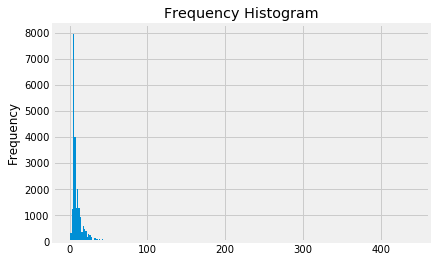

In [107]:
plt.hist(review_per_product_df['numberofreviews'], bins=250)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency')
plt.show()

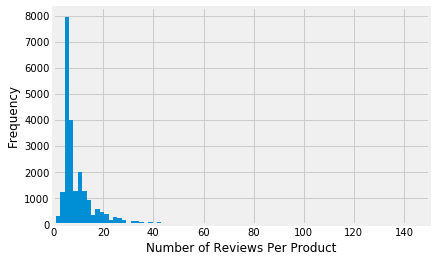

In [108]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(review_per_product_df['numberofreviews'], bins=250)
plt.xlabel('Number of Reviews Per Product')
plt.ylabel('Frequency')
ax.set_xlim(xmin=0.0, xmax=150)
plt.show()

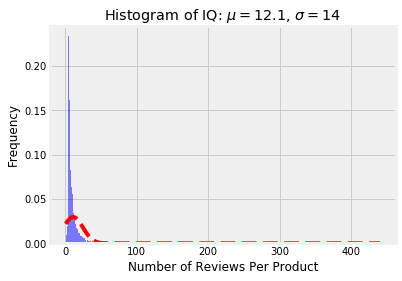

In [109]:
mu = np.mean(review_per_product_df['numberofreviews'].values) # mean of distribution
sigma = np.std(review_per_product_df['numberofreviews'].values)  # standard deviation of distribution

num_bins = 500
# the histogram of the data
n, bins, patches = plt.hist(review_per_product_df['numberofreviews'].values, num_bins, normed=1, facecolor='blue', alpha=0.5)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
plt.xlabel('Number of Reviews Per Product')
plt.ylabel('Frequency')
plt.title(r'Histogram of IQ: $\mu=12.1$, $\sigma=14$')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

In [110]:
review_per_product_df.describe()

,numberofreviews
count,22943.000000
mean,11.429281
std,13.471051
min,1.000000
25%,5.000000
50%,7.000000
75%,12.000000
max,440.000000


A product has minimum 4 reviews.

In [111]:
num_of_reviews_array = review_per_product_df["numberofreviews"].as_matrix()

*Normality Tests*

In [112]:
#TODO:CHECK SKEWWNESS RATE

In [113]:
# normality test
def ShapiroNormalityTest(array):
    stat, p = shapiro(array)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

ShapiroNormalityTest(num_of_reviews_array)

Statistics=0.491, p=0.000
Sample does not look Gaussian (reject H0)


In [114]:
def NormalityTest(array):
    k2, p = normaltest(array)
    alpha = 1e-3
    print('Statistics=%.3f, p=%.3f' % ( k2, p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
      print("The null hypothesis can be rejected:")
    else:
       print("The null hypothesis cannot be rejected:")

NormalityTest(num_of_reviews_array)

Statistics=29616.757, p=0.000
The null hypothesis can be rejected:


It seems number of reviews does not distiributed normally

In [115]:
Q1 = review_per_product_df["numberofreviews"].quantile(0.25)
Q3 = review_per_product_df["numberofreviews"].quantile(0.75)

print(Q1)
print(Q3)

5.0
12.0


%75 of the values are under 13.

*Outlier removing*

In [116]:
review_per_product_df_without_outliers=review_per_product_df["numberofreviews"][np.abs(review_per_product_df["numberofreviews"]-review_per_product_df["numberofreviews"].mean()) <= (3*review_per_product_df["numberofreviews"].std())]
# keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.

In [117]:
review_per_product_df_without_outliers.shape

(22530,)

In [118]:
x=review_per_product_df["numberofreviews"][~(np.abs(review_per_product_df["numberofreviews"]-review_per_product_df["numberofreviews"].mean()) > (3*review_per_product_df["numberofreviews"].std()))]
x.shape

(22530,)

In [119]:
filt_df = review_per_product_df.loc[:, review_per_product_df.columns != 'asin']

In [120]:
low = .05
high = .95
quant_df = filt_df.quantile([low, high])
print(quant_df)

      numberofreviews
0.05              4.0
0.95             32.0


In [121]:
filt_df = filt_df.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & 
                                    (x < quant_df.loc[high,x.name])], axis=0)

In [122]:
filt_df = pd.concat([review_per_product_df.loc[:,'asin'], filt_df], axis=1)

In [123]:
filt_df.dropna(inplace=True)
filt_df.shape

(20210, 2)

In [124]:
NormalityTest(filt_df["numberofreviews"].values)

Statistics=6040.128, p=0.000
The null hypothesis can be rejected:


In [125]:
ShapiroNormalityTest(filt_df["numberofreviews"].values)

Statistics=0.784, p=0.000
Sample does not look Gaussian (reject H0)


In [126]:
#TODO: LogTransformation
#df_log[df_log.isnull()] = -1
#review_per_product_df["numberofreviews"] = review_per_product_df["numberofreviews"].applymap(lambda x: np.log(x+1))

In [127]:
review_per_brand_df = df_review_combined.groupby("brand").count()[["reviewtext"]]
review_per_brand_df.sort_values(by='reviewtext', ascending=False)

,reviewtext
brand,
Casio,1936
Timex,1399
Invicta,820
Carhartt,783
Allegra K,691
Geneva,685
Leg Avenue,658
Unknown,587
Rothco,559


Number of reviews per brand are showned.
Casio, Timex, Invicta have the most of the reviews

## Checking Sales Rank

In [128]:
import ast

In [129]:
columnnames_sales=['metadataid', 'asin', 'salesrank','helpful',"price"]
df_sales_related = df_review_combined[columnnames_sales]

df_sales_related.dropna(axis = 0, how ='all', inplace = True)
df_sales_related = df_sales_related[df_sales_related["salesrank"] != "NaN" ]
df_sales_related = df_sales_related[df_sales_related["salesrank"] != "n/a" ]
df_sales_related = df_sales_related[df_sales_related["salesrank"] != "na" ]
df_sales_related = df_sales_related[df_sales_related["salesrank"] != "--" ]

df_sales_related.isnull().values.any()

True

In [130]:
df_sales_related.head(1)

,metadataid,asin,salesrank,helpful,price
0,2005401,B00004SR8Z,{'Clothing': 1631},"[8, 11]",12.8


In [131]:
df_sales_related.isnull().sum()

metadataid         0
asin               0
salesrank      11582
helpful            0
price         155376
dtype: int64

In [132]:
df_sales_related["salesrank"].fillna("none",inplace=True)

just_sales_df = df_sales_related[["asin","salesrank"]]
just_sales_df = just_sales_df[just_sales_df["salesrank"] != "none"]

In [133]:
category_sales_df = (pd.DataFrame(just_sales_df['salesrank'].apply(ast.literal_eval).values.tolist(), index=just_sales_df['asin'])
       .stack()
       .reset_index()
       .rename(columns={'level_1':'category_name', 0:'salesrank'})
       )

In [134]:
category_sales_df.head()

,asin,category_name,salesrank
0,B00004SR8Z,Clothing,1631.0
1,B00004SR8Z,Clothing,1631.0
2,B00004SR8Z,Clothing,1631.0
3,B00004SR8Z,Clothing,1631.0
4,B00004SR8Z,Clothing,1631.0


In [135]:
category_sales_df = category_sales_df.drop_duplicates(keep="first")

In [136]:
print("Number of Unique products with Sales Rank: ", category_sales_df['asin'].nunique())

print("Number of Unique products",df_review_combined["asin"].nunique())

print("Number of product without  Sales Rank: ", df_review_combined["asin"].nunique()-category_sales_df['asin'].nunique())

Number of Unique products with Sales Rank:  21719
Number of Unique products 22943
Number of product without  Sales Rank:  1224


In [137]:
df_sales_related = df_sales_related.merge(category_sales_df, on=['asin'], how='left')

In [138]:
df_sales_related.head()   

,metadataid,asin,salesrank_x,helpful,price,category_name,salesrank_y
0,2005401,B00004SR8Z,{'Clothing': 1631},"[8, 11]",12.8,Clothing,1631.0
1,2005401,B00004SR8Z,{'Clothing': 1631},"[1, 1]",12.8,Clothing,1631.0
2,2005401,B00004SR8Z,{'Clothing': 1631},"[0, 0]",12.8,Clothing,1631.0
3,2005401,B00004SR8Z,{'Clothing': 1631},"[0, 0]",12.8,Clothing,1631.0
4,2005401,B00004SR8Z,{'Clothing': 1631},"[0, 0]",12.8,Clothing,1631.0


In [139]:
salesrank = df_sales_related.groupby("asin").mean()[["salesrank_y"]]

In [140]:
salesrank

,salesrank_y
asin,
0000031887,8547.0
0123456479,16987.0
1608299953,818.0
1617160377,1137.0
B00001W0KA,11999.0
B00001WRHJ,22838.0
B00004SR8W,5327.0
B00004SR8Z,1631.0
B00004SR9P,4429.0


## 1) What is the relation between the reviews and the helpfulness?

Having a dataframe has related columns with reviews and hepfulness

In [141]:
# from Cases.Takeaway.Codes.TakeawayCase import PreProcessingTakeaway
# ta_data_root = "C:/Users/bengisu.oniz/PyProjects/Main/Cases/Takeaway/Data/"
# df_review_combined = PreProcessingTakeaway(ta_data_root)

columnnames_helpfulness_reviews = ["metadataid", 'asin', 'reviewid', 'reviewerid', 'reviewername', 'helpful',
                                   "reviewtext", "overall"]

def CreatingDfBasedOnColumns(columns):
    helpfulness_reviews_df = df_review_combined[columns]
    return helpfulness_reviews_df

helpfulness_reviews_df = CreatingDfBasedOnColumns(columnnames_helpfulness_reviews)

Parsing the helpful column to calculate the helpfullness percentage

In [142]:
def parseStr(s):
    list = []
    s = s.replace("[", "")
    s = s.replace("]", "")
    segments = s.split(',')
    for s in segments:
        list.append(int(s.strip()))
    return list


def HavingHelpfulPercentage(helpfulness_reviews_df):
    helpfulness_reviews_df['helpful_list'] = helpfulness_reviews_df['helpful'].map(lambda name: parseStr(name))
    helpfullnessscores_df = helpfulness_reviews_df['helpful_list'].apply(pd.Series)
    mapping_columnnames = {helpfullnessscores_df.columns[0]: 'helpfulclick',
                           helpfullnessscores_df.columns[1]: 'totalclick'}
    helpfullnessscores_df = helpfullnessscores_df.rename(columns=mapping_columnnames)
    helpfullnessscores_df['helpfulclick'] = pd.to_numeric(helpfullnessscores_df['helpfulclick'])
    helpfullnessscores_df['totalclick'] = pd.to_numeric(helpfullnessscores_df['totalclick'])

    helpfulness_percentage = []

    for index, row in helpfullnessscores_df.iterrows():
        if row["totalclick"] == 0:
            helpfulness_percentage.append(0)
        else:
            per = row["helpfulclick"] / row["totalclick"] * 100
            helpfulness_percentage.append(per)

    helpfullnessscores_df['helpfulness_percentage'] = helpfulness_percentage
    helpfulness_reviews_df['helpfulness_percentage'] = helpfullnessscores_df['helpfulness_percentage']
    helpfulness_reviews_df['helpfulclick'] = helpfullnessscores_df['helpfulclick']
    helpfulness_reviews_df['totalclick'] = helpfullnessscores_df['totalclick']


HavingHelpfulPercentage(helpfulness_reviews_df)

In [143]:
helpfulness_reviews_df.head(1)

,metadataid,asin,reviewid,reviewerid,reviewername,helpful,reviewtext,overall,helpful_list,helpfulness_percentage,helpfulclick,totalclick
0,2005401,B00004SR8Z,84,A3SC04DC5TLYSP,Amanda Winstead,"[8, 11]",This pouch is lightweight and comfortable to w...,3.0,"[8, 11]",72.727273,8,11


Using nltk library to take tokens of the review texts

In [144]:
import nltk
nltk.download('punkt') #one-time download
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords') #one-time download

def GetDistinctNonstopWordsLength(text):
    words = set(word_tokenize(text)) - set(stopwords.words('english'))  # getting important words
    length = len(words)
    return length


helpfulness_reviews_df['review_word_count'] = helpfulness_reviews_df['reviewtext'].map(
    lambda text: GetDistinctNonstopWordsLength(text))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bengisu.oniz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bengisu.oniz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                        helpfulness_percentage   overall  review_word_count
helpfulness_percentage                1.000000 -0.050564           0.200142
overall                              -0.050564  1.000000          -0.050515
review_word_count                     0.200142 -0.050515           1.000000


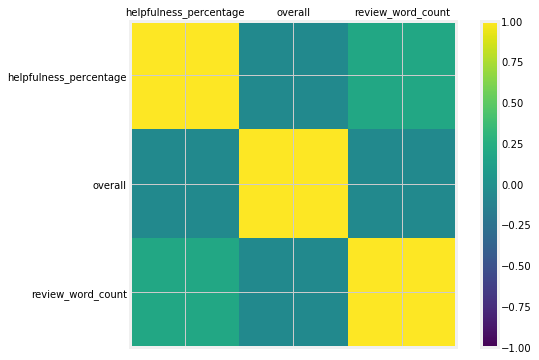

In [145]:
corrnames = ['helpfulness_percentage', 'overall', 'review_word_count']

def CheckingCorrelations(columnnames):
    correlations = helpfulness_reviews_df[columnnames].corr()
    print(correlations)

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, 3, 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(corrnames)
    ax.set_yticklabels(corrnames)
    plt.show()
    ax.tick_params(labelsize=13)


CheckingCorrelations(corrnames)

                        helpfulness_percentage  review_word_count
helpfulness_percentage                1.000000           0.200142
review_word_count                     0.200142           1.000000


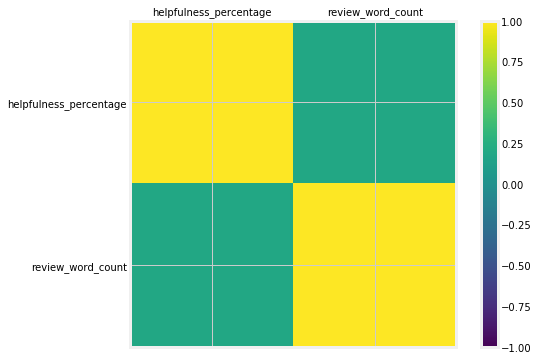

In [146]:
corrnames = ['helpfulness_percentage', 'review_word_count']

def CheckingCorrelations(columnnames):
    correlations = helpfulness_reviews_df[columnnames].corr()
    print(correlations)

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, 2, 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(corrnames)
    ax.set_yticklabels(corrnames)
    plt.show()
    ax.tick_params(labelsize=25)


CheckingCorrelations(corrnames)

![alt text](https://github.com/adam-p/markdown-here/raw/master/src/common/images/icon48.png "Logo Title Text 1")

It is seen that there is a low(0.20) correlation between helpfulness and the number of words in the reviews. Since there is a low relationship between these two features, and it is not easy to stimulate the people to write reviews, it would be better if there are default reviews (from combo box) that are short and significant to the point. Default values can be selected from the most written reviews. If a reviewer cannot find any reviews that reflect her/his ideas, s/he *"other"* option to write his/her comments in the free text field.

## 3) Is there a relationship between price and reviews?

l want to check the prices of the products. 

**---------Price---------**

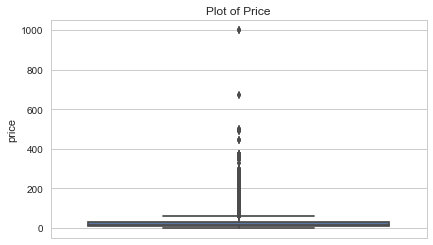

In [147]:
sns.set(style="whitegrid")
ax = sns.boxplot(y=df_review_combined["price"])
#df_review_combined.boxplot(column='price') 
plt.title('Plot of Price')
plt.show()

It seems there are so many prices which are out of the first and third quartiel.


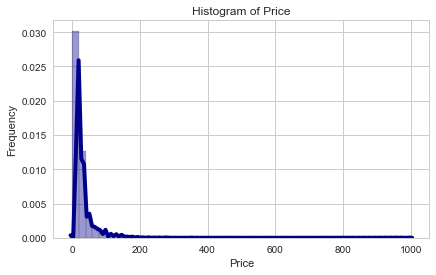

In [148]:
sns.distplot(df_review_combined["price"], hist=True, kde=True, 
               bins=int(50), color = 'darkblue', 
               hist_kws={'edgecolor':'black'},
               kde_kws={'linewidth': 4})
plt.title('Histogram of Price' )
plt.xlabel("Price")
plt.ylabel('Frequency')
plt.show()

Most of the prica data agglomerated between 0 and 150

**PRICE & NUMBER OF REVIEWS PER PRODUCT**

In [172]:
price_of_product_df = df_review_combined[['asin','price']].drop_duplicates()

In [173]:
price_of_product_df.shape

(22943, 2)

In [174]:
print("Nullity Check:\n", pd.isnull(price_of_product_df).any())

Nullity Check:
 asin     False
price     True
dtype: bool


In [175]:
price_of_product_df.dropna(inplace=True)

In [176]:
price_of_product_df.head(1)

,asin,price
0,B00004SR8Z,12.8


In [177]:
review_per_product_df.head(1)

,numberofreviews,asin
0,21,0000031887


In [178]:
reviews_df = review_per_product_df.reset_index()

In [179]:
price_reviews = price_of_product_df.merge(reviews_df, on=['asin'], how='inner')

In [180]:
price_reviews.head()

,asin,price,index,numberofreviews
0,B00004SR8Z,12.80,7,20
1,B00066TWMU,12.41,443,12
2,B0008172YS,5.79,735,9
3,B0006NU6KK,13.13,520,5
4,B00001W0KA,22.14,4,6


In [182]:
reviewlength_per_product_df = helpfulness_reviews_df.groupby("asin").sum()[["review_word_count"]]
reviewlength_per_product_df.head()

,review_word_count
asin,
0000031887,665
0123456479,208
1608299953,332
1617160377,616
B00001W0KA,242


In [183]:
price_reviewlen_df = price_of_product_df.merge(reviewlength_per_product_df, on=['asin'], how='inner')

In [184]:
price_reviewlen_df.head(1)

,asin,price,review_word_count
0,B00004SR8Z,12.8,664


In [185]:
price_reviewlen_df = price_reviewlen_df.merge(reviews_df, on=['asin'], how='inner')

In [186]:
price_reviewlen_df.head(1)

,asin,price,review_word_count,index,numberofreviews
0,B00004SR8Z,12.8,664,7,20


                      price  review_word_count  numberofreviews
price              1.000000           0.017837        -0.096515
review_word_count  0.017837           1.000000         0.921238
numberofreviews   -0.096515           0.921238         1.000000


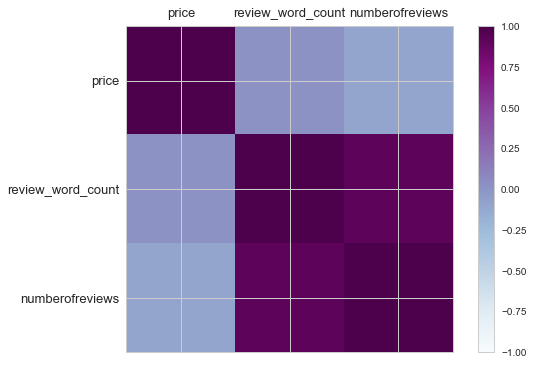

In [188]:
corrnames=['price', 'review_word_count',"numberofreviews"]

def CheckingCorrelations(columnnames):
    correlations = price_reviewlen_df[corrnames].corr()
    print(correlations)

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1, cmap='BuPu')
    fig.colorbar(cax)
    ticks = np.arange(0, 3, 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(corrnames)
    ax.set_yticklabels(corrnames)
    ax.tick_params(labelsize=13)

    plt.show()

CheckingCorrelations(corrnames)

![alt text](https://github.com/adam-p/markdown-here/raw/master/src/common/images/icon48.png "Logo Title Text 1")


Correlation of the price and the length of reviews are so low!

This also shows that some of the reviews are long.

### SalesRank and Review

In [164]:
df_sales_review = salesrank.merge(price_reviewlen_df, on=['asin'], how='inner')

                   salesrank_y  review_word_count  numberofreviews
salesrank_y           1.000000          -0.074485        -0.082760
review_word_count    -0.074485           1.000000         0.921238
numberofreviews      -0.082760           0.921238         1.000000


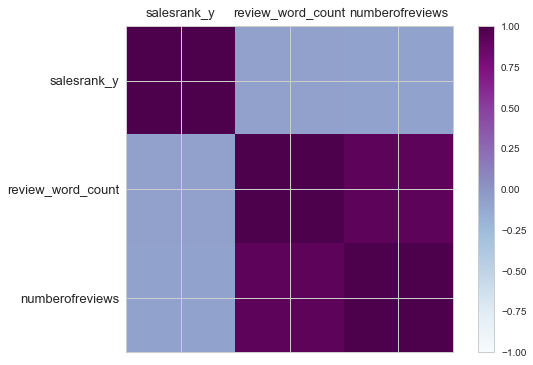

In [165]:
corrnames=['salesrank_y', 'review_word_count',"numberofreviews"]


def CheckingCorrelations(columnnames):
    correlations = df_sales_review[columnnames].corr()
    print(correlations)
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1, cmap='BuPu')
    fig.colorbar(cax)
    ticks = np.arange(0, 3, 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(columnnames)
    ax.set_yticklabels(columnnames)
    ax.tick_params(labelsize=13)

    plt.show()

CheckingCorrelations(corrnames)

## 4) Which group of reviewers is more valuable to the business?

Firstly l want to check if the relationship between sales rank and helpfullness

In [189]:
helpfulness_reviews_df["helpfulness_percentage_WithNAN"]=helpfulness_reviews_df["helpfulness_percentage"].replace(0.0, np.nan)
helpfulness_reviews_df["overall_WithNAN"]=helpfulness_reviews_df["overall"].replace(0.0, np.nan)

In [190]:
helpfullness_per_product_df = helpfulness_reviews_df.groupby("reviewerid").mean()[["helpfulness_percentage_WithNAN","overall_WithNAN"]]

helpfullness_per_product_df.rename(columns={'helpfulness_percentage_WithNAN': 'avg_helpfullness_percentage'}, inplace=True)
helpfullness_per_product_df.rename(columns={'overall_WithNAN': 'avg_overall_product_score'}, inplace=True)

helpfullness_per_product_df.head()

,avg_helpfullness_percentage,avg_overall_product_score
reviewerid,,
A001114613O3F18Q5NVR6,87.5,4.857143
A00146182PNM90WNNAZ5Q,72.5,4.000000
A00165422B2GAUE3EL6Z0,NaN,4.333333
A00338282E99B8OR2JYTZ,NaN,4.600000
A00354001GE099Q1FL0TU,NaN,4.400000


In [191]:
review_per_reviewer_df = df_review_combined.groupby("reviewerid").count()[["reviewtext"]]
review_per_reviewer_df.rename(columns={'reviewtext': 'numberofreviews'}, inplace=True)

In [192]:
reviewers_df = helpfullness_per_product_df.merge(review_per_reviewer_df, on="reviewerid", how='inner')

In [193]:
reviewers_df.head(2)

,avg_helpfullness_percentage,avg_overall_product_score,numberofreviews
reviewerid,,,
A001114613O3F18Q5NVR6,87.5,4.857143,7
A00146182PNM90WNNAZ5Q,72.5,4.000000,7


In [194]:
reviewers_df.describe()

,avg_helpfullness_percentage,avg_overall_product_score,numberofreviews
count,29608.000000,39210.000000,39210.000000
mean,90.227423,4.236876,6.687631
std,14.885797,0.624470,3.498658
min,5.882353,1.000000,1.000000
25%,83.333333,3.857143,5.000000
50%,100.000000,4.333333,6.000000
75%,100.000000,4.727273,7.000000
max,100.000000,5.000000,136.000000


In [195]:
len(reviewers_df[reviewers_df['avg_helpfullness_percentage']==100])

16510

l want to see how to distributions look like

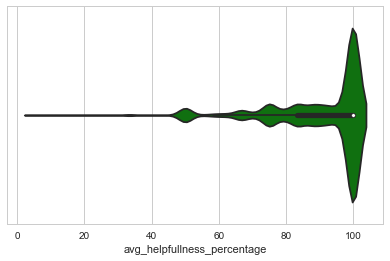

In [196]:
sns.set(style="whitegrid")
ax = sns.violinplot(x=reviewers_df["avg_helpfullness_percentage"],color="green")
plt.show()

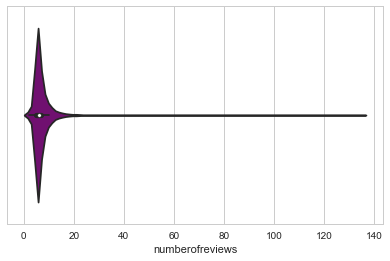

In [197]:
sns.set(style="whitegrid")
ax = sns.violinplot(x=reviewers_df["numberofreviews"],color="purple")
plt.show()

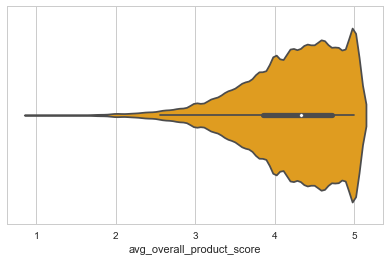

In [198]:
sns.set(style="whitegrid")
ax = sns.violinplot(x=reviewers_df["avg_overall_product_score"],color="orange")
plt.show()

![alt text](https://github.com/adam-p/markdown-here/raw/master/src/common/images/icon48.png "Logo Title Text 1")



We can say that the most valuable reviewers are the ones whose average helpfulness percentage is 100 & the number of reviews are higher than 7 (which is 3rd interquartile range)

In [199]:
len(reviewers_df[(reviewers_df['avg_helpfullness_percentage']==100) & (reviewers_df['numberofreviews'] < 7)])

10773

**Clustering of the reviewers**

It is better to take the reviewers whose number of reviews are less than 20 at the first place. Then do clustering analyses. It will help us another point of view.

In [200]:
reviewer_less = reviewers_df[reviewers_df['numberofreviews'] < 20]

In [201]:
reviewer_less.shape

(38723, 3)

In [202]:
Q1 = reviewer_less.quantile(0.25)
Q3 = reviewer_less.quantile(0.75)
IQR = Q3 - Q1

In [203]:
Q3

avg_helpfullness_percentage    100.000000
avg_overall_product_score        4.730303
numberofreviews                  7.000000
Name: 0.75, dtype: float64

In [204]:
reviewer_less_without_outliers = reviewer_less[~((reviewer_less < (Q1 - 1.5 * IQR)) |(reviewer_less > (Q3 + 1.5 * IQR))).any(axis=1)]
print(reviewer_less_without_outliers.head())

                       avg_helpfullness_percentage  avg_overall_product_score  \
reviewerid                                                                      
A001114613O3F18Q5NVR6                         87.5                   4.857143   
A00146182PNM90WNNAZ5Q                         72.5                   4.000000   
A00165422B2GAUE3EL6Z0                          NaN                   4.333333   
A00338282E99B8OR2JYTZ                          NaN                   4.600000   
A00354001GE099Q1FL0TU                          NaN                   4.400000   

                       numberofreviews  
reviewerid                              
A001114613O3F18Q5NVR6                7  
A00146182PNM90WNNAZ5Q                7  
A00165422B2GAUE3EL6Z0                6  
A00338282E99B8OR2JYTZ                5  
A00354001GE099Q1FL0TU                5  


In [205]:
reviewer_less_without_outliers.dropna(inplace=True)

In [206]:
columns=reviewer_less_without_outliers.columns

In [207]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
np_scaled = scaler.fit_transform(reviewer_less_without_outliers)

In [208]:
np_scaled

array([[0.7       , 0.94155844, 0.625     ],
       [0.34      , 0.59090909, 0.625     ],
       [1.        , 0.67272727, 0.375     ],
       ...,
       [1.        , 0.65909091, 0.5       ],
       [1.        , 0.50909091, 0.375     ],
       [0.4       , 0.38636364, 0.5       ]])

In [209]:
df_scaled = pd.DataFrame(np_scaled, columns=columns)

In [210]:
df_scaled

,avg_helpfullness_percentage,avg_overall_product_score,numberofreviews
0,0.700000,0.941558,0.625
1,0.340000,0.590909,0.625
2,1.000000,0.672727,0.375
3,0.400000,0.672727,0.375
4,0.907692,0.754545,0.375
5,1.000000,0.918182,0.375
6,1.000000,1.000000,0.375
7,1.000000,0.941558,0.625
8,0.400000,0.918182,0.375
9,0.700000,1.000000,0.625


In [211]:
from sklearn.cluster import KMeans   #importing libraries for the model
from sklearn.metrics import silhouette_samples, silhouette_score

In [212]:
for n_cluster in range(2, 20):
    kmeans = KMeans(n_clusters=n_cluster).fit(df_scaled)
    label = kmeans.labels_
    sil_coeff = silhouette_score(df_scaled, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.39194422491649483
For n_clusters=3, The Silhouette Coefficient is 0.3427336304237664
For n_clusters=4, The Silhouette Coefficient is 0.35259943114720754
For n_clusters=5, The Silhouette Coefficient is 0.3516893575118938
For n_clusters=6, The Silhouette Coefficient is 0.3121631327431938
For n_clusters=7, The Silhouette Coefficient is 0.32047461541703987
For n_clusters=8, The Silhouette Coefficient is 0.3264656882002362
For n_clusters=9, The Silhouette Coefficient is 0.33248561981156566
For n_clusters=10, The Silhouette Coefficient is 0.3327241010531976
For n_clusters=11, The Silhouette Coefficient is 0.31867433108210835
For n_clusters=12, The Silhouette Coefficient is 0.3244815282118124
For n_clusters=13, The Silhouette Coefficient is 0.3104685659814356
For n_clusters=14, The Silhouette Coefficient is 0.31883954326577857
For n_clusters=15, The Silhouette Coefficient is 0.31943885628906044
For n_clusters=16, The Silhouette Coefficient is 

In [213]:
n_clusters=2
clusterer = KMeans(n_clusters=n_clusters,random_state=42).fit(df_scaled)
centers = clusterer.cluster_centers_
cluster_labels = clusterer.fit_predict(df_scaled)

In [214]:
reviewer_less_without_outliers["cluster"] = cluster_labels

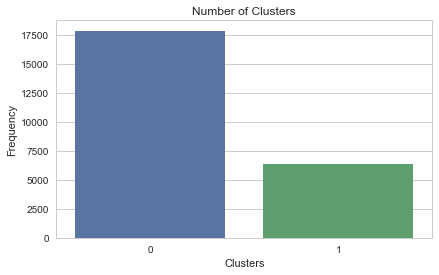

In [215]:
sns.countplot(x="cluster", data=reviewer_less_without_outliers)    
plt.xlabel('Clusters')
plt.ylabel('Frequency')
plt.title('Number of Clusters')
plt.show()

In [216]:
reviewer_less_without_outliers.groupby('cluster', as_index=False).mean()

,cluster,avg_helpfullness_percentage,avg_overall_product_score,numberofreviews
0,0,98.825129,4.306770,6.035009
1,1,77.137316,4.084679,6.263724


This table indicates that the reviewers who belong to Cluster 0 are the most valuable.
Reviews of these reviewers are considered as insights for the products. 
Maybe there is a trustworthy score of the reviewers. Other customers consider trustworthy score of the reviewers.

## 2) What is the review behavior among different categories?

In [217]:
columns_categories = ["asin","categories"]
categories_df = CreatingDfBasedOnColumns(columns_categories)

In [218]:
def ParseStrDf(s):
    list = []
    s = s.replace("[[", "")
    s = s.replace("]]", "")
    s = s.replace("'", "")
    segments = s.split(',')
    for s in segments:
        list.append(s.strip())
    return list

#TODO:EVAL s=eval(s)

In [219]:
categories_df['categories_list'] = categories_df['categories'].map(lambda name: ParseStrDf(name))
category_splitted_df = categories_df['categories_list'].apply(pd.Series)

In [220]:
category_splitted_df = category_splitted_df.rename(columns = lambda x : 'category_' + str(x))

for i in (category_splitted_df.columns):
    print(i+ " Nullity Check:", pd.isnull(category_splitted_df[i]).count())

category_0 Nullity Check: 262222
category_1 Nullity Check: 262222
category_2 Nullity Check: 262222
category_3 Nullity Check: 262222
category_4 Nullity Check: 262222
category_5 Nullity Check: 262222
category_6 Nullity Check: 262222
category_7 Nullity Check: 262222
category_8 Nullity Check: 262222
category_9 Nullity Check: 262222
category_10 Nullity Check: 262222
category_11 Nullity Check: 262222
category_12 Nullity Check: 262222
category_13 Nullity Check: 262222
category_14 Nullity Check: 262222
category_15 Nullity Check: 262222
category_16 Nullity Check: 262222
category_17 Nullity Check: 262222
category_18 Nullity Check: 262222
category_19 Nullity Check: 262222
category_20 Nullity Check: 262222
category_21 Nullity Check: 262222
category_22 Nullity Check: 262222
category_23 Nullity Check: 262222
category_24 Nullity Check: 262222
category_25 Nullity Check: 262222
category_26 Nullity Check: 262222
category_27 Nullity Check: 262222
category_28 Nullity Check: 262222
category_29 Nullity Chec

In [221]:
categories_df["categories"].sample(100) #.values

150019    [['Clothing, Shoes & Jewelry', 'Women', 'Cloth...
164584    [['Clothing, Shoes & Jewelry', 'D', 'Dockers']...
129501    [['Clothing, Shoes & Jewelry', 'Shoes & Access...
125995    [['Clothing, Shoes & Jewelry', 'Women', 'Shoes...
210137    [['Clothing, Shoes & Jewelry', 'Women', 'Cloth...
22664     [['Health & Personal Care', 'Health Care', 'Fo...
191785    [['Clothing, Shoes & Jewelry', 'Women', 'Cloth...
63653     [['Clothing, Shoes & Jewelry', 'Men', 'Clothin...
55659     [['Clothing, Shoes & Jewelry', 'Novelty, Costu...
111444    [['Clothing, Shoes & Jewelry', 'Jewelry: Inter...
4834      [['Sports & Outdoors', 'Clothing', 'Men', 'Shi...
117085    [['Clothing, Shoes & Jewelry', 'Shoes & Access...
164393    [['Clothing, Shoes & Jewelry', 'Jewelry: Inter...
272757    [['Clothing, Shoes & Jewelry', 'Women', 'Cloth...
12426     [['Sports & Outdoors', 'Clothing', 'Women', 'S...
207010    [['Clothing, Shoes & Jewelry', 'Shoes & Access...
250382    [['Clothing, Shoes & Jewelry',

In [222]:
len(categories_df["categories"].unique())

6286

In [223]:
category_splitted_df.fillna("none", inplace=True)

for i in (category_splitted_df.columns):
    num_nones = len(category_splitted_df[category_splitted_df[i]=="none"])
    len_of_column = len(category_splitted_df[i])
    per = num_nones/len_of_column*100
    print(i + " None value check:",num_nones,", Length of the column", len_of_column,", Percentage of empty columns",per)

category_0 None value check: 0 , Length of the column 262222 , Percentage of empty columns 0.0
category_1 None value check: 0 , Length of the column 262222 , Percentage of empty columns 0.0
category_2 None value check: 0 , Length of the column 262222 , Percentage of empty columns 0.0
category_3 None value check: 1862 , Length of the column 262222 , Percentage of empty columns 0.7100853475299556
category_4 None value check: 4582 , Length of the column 262222 , Percentage of empty columns 1.7473743621816629
category_5 None value check: 27125 , Length of the column 262222 , Percentage of empty columns 10.344288427363074
category_6 None value check: 68813 , Length of the column 262222 , Percentage of empty columns 26.242268001922035
category_7 None value check: 76155 , Length of the column 262222 , Percentage of empty columns 29.042185628970874
category_8 None value check: 86406 , Length of the column 262222 , Percentage of empty columns 32.95146860293949
category_9 None value check: 10137

In [224]:
categories_df["category_0"]=category_splitted_df["category_0"]
categories_df["category_1"]=category_splitted_df["category_1"]
categories_df["category_2"]=category_splitted_df["category_2"]

In [225]:
categories_review_df = categories_df.merge(price_reviewlen_df,on=["asin"],how="inner")

In [226]:
categories_review_df = categories_review_df.groupby(['category_0', 'category_1','category_2']).agg({'review_word_count':'sum','numberofreviews':'sum','price':'mean'})

In [227]:
categories_review_df.head()

review_word_count  \
category_0 category_1               category_2                                    
Arts       Crafts & Sewing          Beading & Jewelry-Making              29097   
                                    Craft Supplies                         2286   
                                    Sewing                                 2588   
Automotive Exterior Accessories     Snow & Ice                             3388   
           Motorcycle & Powersports Protective Gear                       10628   

                                                              numberofreviews  \
category_0 category_1               category_2                                  
Arts       Crafts & Sewing          Beading & Jewelry-Making             1245   
                                    Craft Supplies                         81   
                                    Sewing                                 74   
Automotive Exterior Accessories     Snow & Ice                            121   
           Motorcycle & Powersports Protective Gear                       374   

                                                                  price  
category_0 category_1               category_2                           
Arts       Crafts & Sewing          Beading & Jewelry-Making  10.338315  
                                    Craft Supplies             3.590000  
                                    Sewing                    10.350833  
Automotive Exterior Accessories     Snow & Ice                20.000000  
           Motorcycle & Powersports Protective Gear           22.896458

In [228]:
categories_review_df.sort_values(by=['numberofreviews'], ascending=False).head(10)

review_word_count  \
category_0        category_1      category_2                                                              
Clothing          Shoes & Jewelry Women                                                        25954317   
                                  Women]                                                       16634535   
                                  Men                                                           7446247   
                                  Novelty                                                       6837670   
                                  Luggage & Travel Gear                                         3820422   
                                  Shoes & Accessories: International Shipping Ava...            2799473   
                                  New Arrivals]                                                 2093061   
                                  Jewelry: International Shipping Available]                    1317440   
                                  Jewelry Outlet]                                                755472   
Sports & Outdoors Clothing        Men                                                            615885   

                                                                                      numberofreviews  \
category_0        category_1      category_2                                                            
Clothing          Shoes & Jewelry Women                                                        840884   
                                  Women]                                                       723625   
                                  Men                                                          249946   
                                  Novelty                                                      222660   
                                  Luggage & Travel Gear                                        100842   
                                  Shoes & Accessories: International Shipping Ava...            78532   
                                  New Arrivals]                                                 53009   
                                  Jewelry: International Shipping Available]                    45916   
                                  Jewelry Outlet]                                               31543   
Sports & Outdoors Clothing        Men                                                           21891   

                                                                                          price  
category_0        category_1      category_2                                                     
Clothing          Shoes & Jewelry Women                                               21.267848  
                                  Women]                                               7.620331  
                                  Men                                                 18.623413  
                                  Novelty                                             13.754319  
                                  Luggage & Travel Gear                               37.309817  
                                  Shoes & Accessories: International Shipping Ava...  69.614502  
                                  New Arrivals]                                       57.895265  
                                  Jewelry: International Shipping Available]          36.074294  
                                  Jewelry Outlet]                                      8.097626  
Sports & Outdoors Clothing        Men                                                 16.897760

As we see there is a high correlation between number of reviews and the word counts. Therefore it is normal to sort the list one of these values. 

When we sort the data frame by the number of reviews, it is seen that Category of Shoes & Jewelry-Women is the most reviewed category. This is not surprising, these are the most common goods that people buy.

In [229]:
categories_review_df.sort_values(by=['numberofreviews']).head(10)

,,,review_word_count,numberofreviews,price
category_0,category_1,category_2,,,
Electronics,Camera & Photo,Bags & Cases,436,16,54.95
Sports & Outdoors,Cycling,Accessories,1116,16,10.00
Toys & Games,Novelty & Gag Toys,Temporary Tattoos],284,16,6.28
Baby Products,Diapering,Cloth Diapers,320,16,6.24
Toys & Games,Novelty & Gag Toys],[Toys & Games,312,16,9.99
Sports & Outdoors,Accessories,Traction Cleats],964,16,36.21
Clothing,Shoes & Jewelry,Anuschka],740,25,59.06
Electronics,GPS & Navigation,Sports & Handheld GPS,1340,25,159.99
Toys & Games,Dress Up & Pretend Play,Beauty & Fashion,800,25,10.28


it is also seen that Category of Electronics-Camera & Photo	-Bags & Cases 
Sports & Outdoors-Cycling-Accessories are the least reviewed categories.

*Another way of finding categories*

In [230]:
categories_df['categories_list_evalled'] = categories_df['categories'].map(lambda string: ast.literal_eval(string))

In [231]:
categories_df['categories_list_evalled'].sample(5)

236605    [[Clothing, Shoes & Jewelry, Men, Clothing, Sh...
187859    [[Clothing, Shoes & Jewelry, Novelty, Costumes...
277134    [[Clothing, Shoes & Jewelry, Women], [Clothing...
213755    [[Clothing, Shoes & Jewelry, Women, Accessorie...
116834    [[Clothing, Shoes & Jewelry, Men, Clothing, Je...
Name: categories_list_evalled, dtype: object

In [232]:
type(categories_df['categories_list_evalled'].loc[33232])

list

In [233]:
category_splitted__second_df = categories_df['categories_list_evalled'].apply(pd.Series)

In [234]:
category_splitted__second_df = category_splitted__second_df.rename(columns = lambda x : 'cat_' + str(x))

In [235]:
category_splitted__second_df.head(5)

,cat_0,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,cat_7,cat_8,cat_9,cat_10,cat_11
0,"[Clothing, Shoes & Jewelry, Luggage & Travel G...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[Clothing, Shoes & Jewelry, Luggage & Travel G...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[Clothing, Shoes & Jewelry, Luggage & Travel G...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"[Clothing, Shoes & Jewelry, Luggage & Travel G...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"[Clothing, Shoes & Jewelry, Luggage & Travel G...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [236]:
len(category_splitted__second_df["cat_0"])

262222

## 5) Is there a relation between reviews from products which are bought together?

In [237]:
columns_related = ["asin","related"]
related_df = CreatingDfBasedOnColumns(columns_related)

In [238]:
print("Nullity Check:",pd.isnull(related_df).sum())

Nullity Check: asin         0
related    345
dtype: int64


In [239]:
related_df.dropna(inplace=True)

In [240]:
related_df.shape

(261877, 2)

In [244]:
len_list=[]
for i in range(10,70,10):
    length= len(related_df["related"].loc[i])
    len_list.append(length)

len_set = set(len_list)

print("Length of the list", len(len_list),"Length of the set",len(len_set))


Length of the list 6 Length of the set 3


The lenght of column "related" are is fixed for every item.

In [245]:
related_df = (pd.DataFrame(related_df["related"].apply(ast.literal_eval).values.tolist(), index=related_df['asin'])
       .stack()
       .reset_index()
       .rename(columns={'level_1': 'reatednesstype', 0: 'related_producs'})
              )


boughttogether_df= related_df[(related_df['reatednesstype']=="also_bought")]
boughttogether_df.drop('reatednesstype', axis=1, inplace=True)
boughttogether_df.rename(columns={'related_producs': 'products_bought_together'}, inplace=True)

# viewedtogether_df= related_df[(related_df['reatednesstype']=="also_viewed")]
# viewedtogether_df.drop('reatednesstype', axis=1,inplace=True)
# viewedtogether_df.rename(columns={'related_producs': 'products_viewed_together'}, inplace=True)


In [246]:
boughttogether_splitted_df = boughttogether_df['products_bought_together'].apply(pd.Series)
boughttogether_splitted_df = boughttogether_splitted_df.rename(columns = lambda x : 'bought_together_' + str(x))

productlist = boughttogether_splitted_df.columns
productlist=list(productlist)

for i in productlist:
    index = productlist.index(i)
    if index < 5:
        boughttogether_df[i]=boughttogether_splitted_df[i]


boughttogether_df.drop('products_bought_together', axis=1, inplace=True)

boughttogether_df.columns

Index(['asin', 'bought_together_0', 'bought_together_1', 'bought_together_2',
       'bought_together_3', 'bought_together_4'],
      dtype='object')

In [247]:
boughttogether_df.head(2)

,asin,bought_together_0,bought_together_1,bought_together_2,bought_together_3,bought_together_4
0,B00004SR8Z,B004RJWFDU,B00920ZC3O,B00920ZC3Y,B004RJWFN0,B0054IH8SA
2,B00004SR8Z,B004RJWFDU,B00920ZC3O,B00920ZC3Y,B004RJWFN0,B0054IH8SA


In [248]:
price_reviewlen_df.head(2)

,asin,price,review_word_count,index,numberofreviews
0,B00004SR8Z,12.80,664,7,20
1,B00066TWMU,12.41,338,443,12


In [249]:
df_main = price_reviewlen_df.merge(boughttogether_df, on=['asin'], how='inner')

In [250]:
df_main.sample(2)

,asin,price,review_word_count,index,numberofreviews,bought_together_0,bought_together_1,bought_together_2,bought_together_3,bought_together_4
80914,B00FGQB1C4,1.57,969,22370,42,B00FGP2WNC,B00FGPMV74,B00DM05FV4,B00IK0MTPQ,B00FLXMST2
93071,B00AJ0IT6I,89.99,152,19101,5,B00DYQR5DW,B00DZMIZ0C,B00DZMIYVC,B00E6OPG7S,B00DYY6G6G


In [251]:
df_0 = pd.merge(price_reviewlen_df,boughttogether_df, left_on='asin', right_on='bought_together_0', how='inner')

dropcolumns = ['asin_x','index', 'asin_y', 'bought_together_1', 'bought_together_2','bought_together_3', 'bought_together_4',"price"]

for i in dropcolumns:
    df_0.drop(i, axis=1, inplace=True)

df_0.rename(columns={'review_word_count': 'review_word_count_0',"numberofreviews":"numberofreviews_0"}, inplace=True)


In [252]:
df_1 = pd.merge(price_reviewlen_df,boughttogether_df, left_on='asin', right_on='bought_together_1', how='right')

dropcolumns = ['asin_x','index', 'asin_y', 'bought_together_0', 'bought_together_2','bought_together_3', 'bought_together_4',"price"]

for i in dropcolumns:
    df_1.drop(i, axis=1, inplace=True)

df_1.rename(columns={'review_word_count': 'review_word_count_1',"numberofreviews":"numberofreviews_1"}, inplace=True)


In [253]:
df_2 = pd.merge(price_reviewlen_df,boughttogether_df, left_on='asin', right_on='bought_together_2', how='right')

dropcolumns = ['asin_x','index', 'asin_y', 'bought_together_0', 'bought_together_1','bought_together_3', 'bought_together_4',"price"]

for i in dropcolumns:
    df_2.drop(i, axis=1, inplace=True)

df_2.rename(columns={'review_word_count': 'review_word_count_2',"numberofreviews":"numberofreviews_2"}, inplace=True)

In [254]:
df_3 = pd.merge(price_reviewlen_df,boughttogether_df, left_on='asin', right_on='bought_together_3', how='right')

dropcolumns = ['asin_x','index', 'asin_y', 'bought_together_0', 'bought_together_1','bought_together_2', 'bought_together_4',"price"]

for i in dropcolumns:
    df_3.drop(i, axis=1, inplace=True)

df_3.rename(columns={'review_word_count': 'review_word_count_3',"numberofreviews":"numberofreviews_3"}, inplace=True)


In [255]:
df_4 = pd.merge(price_reviewlen_df,boughttogether_df, left_on='asin', right_on='bought_together_4', how='right')

dropcolumns = ['asin_x','index', 'asin_y', 'bought_together_0', 'bought_together_1','bought_together_2', 'bought_together_3',"price"]

for i in dropcolumns:
    df_4.drop(i, axis=1, inplace=True)

df_4.rename(columns={'review_word_count': 'review_word_count_4',"numberofreviews":"numberofreviews_4"}, inplace=True)

df_4.head()

,review_word_count_4,numberofreviews_4,bought_together_4
0,573.0,11.0,B0000C9ZBX
1,573.0,11.0,B0000C9ZBX
2,573.0,11.0,B0000C9ZBX
3,573.0,11.0,B0000C9ZBX
4,573.0,11.0,B0000C9ZBX


In [256]:
#MEMORY ERROR
#df_main = pd.merge(df_main,df_2, left_on='asin', right_on='bought_together_2', how='left')
#df_main = pd.merge(df_main,df_3, left_on='asin', right_on='bought_together_3', how='left')
#df_main = pd.merge(df_main,df_4, left_on='asin', right_on='bought_together_4', how='left')

In [257]:
df_1 = pd.merge(boughttogether_df,price_reviewlen_df, left_on='bought_together_1', right_on='asin', how='left')
dropcolumns = ['asin_x','index', 'asin_y', 'bought_together_0', 'bought_together_2','bought_together_3', 'bought_together_4',"price"]

for i in dropcolumns:
    df_1.drop(i, axis=1, inplace=True)

df_1.rename(columns={'review_word_count': 'review_word_count_1',"numberofreviews":"numberofreviews_1"}, inplace=True)

df_1.sample(10)

,bought_together_1,review_word_count_1,numberofreviews_1
94750,B00ECMC9WE,NaN,NaN
151570,B00AFXL15A,NaN,NaN
253669,B00HUZW7PY,264.0,12.0
214522,B004YHRAJO,120.0,7.0
197032,B00JVJ274I,NaN,NaN
72977,B00DNFD4FW,NaN,NaN
245839,B00H7VE5R4,NaN,NaN
3198,B006OY38EQ,NaN,NaN
114914,B00HBYGHZA,NaN,NaN
168256,B004I784O0,NaN,NaN


In [258]:
df_1.dropna(inplace=True)

In [259]:
df_1.sample(10)

,bought_together_1,review_word_count_1,numberofreviews_1
199859,B007WPHD92,656.0,22.0
248015,B0086WVMRE,382.0,9.0
233135,B005P1JL04,168.0,7.0
140020,B006F8SXSM,831.0,31.0
219638,B0090UGKJQ,345.0,9.0
85243,B0035LBXUM,465.0,19.0
165795,B0095LJRDQ,810.0,34.0
205896,B00DMWQT1C,630.0,32.0
228403,B00B4022II,377.0,20.0
247964,B00EK5OAES,1398.0,32.0


In [260]:
df_main.sample(10)

,asin,price,review_word_count,index,numberofreviews,bought_together_0,bought_together_1,bought_together_2,bought_together_3,bought_together_4
32358,B0036F9LVK,9.50,525,6901,18,B002JL8JNS,B009NLXZ54,B007B4SXJS,B002JL8JAG,B003T0MGCS
49879,B006ZJ6QW6,23.40,235,14021,8,B006ZJ6Q08,B00KHYSJX4,B00IY2YEP8,B0091PLD3I,B00ENOPRIO
77510,B00BR08NQU,3.98,305,20315,15,B00CCCWJNA,B00A5HTZGS,B00FBI9PHU,B00CVUROTW,B00ABO0MJ4
52334,B005S5B9YS,10.69,236,12741,11,B00CHU90CU,B005649XE4,B005641VIA,B00BNXOLE4,B009OMZCE4
6154,B000922S8G,5.09,889,766,33,B007FH9I8Q,B001V9VLHA,B00GN3KPMQ,B000UG2FFW,B005C4Y456
65023,B007HR877C,44.99,770,14754,28,B00HHFBP2S,B00AY7YMLW,B0026ZQJSO,B00FK8FRT6,B008MPH6OI
104850,B009LAXJDU,11.89,793,18237,30,B00I0XZMRU,B00IDEQAGI,B00HPQWX84,B00I0GW1CG,B00L8LHEQI
20744,B001GBLMIG,1.47,543,4308,23,B0075MNRLU,B00AOOZWHI,B00C3LCRUA,B00BPY8S72,B001BR0KCO
89604,B00BPYUL9K,0.99,316,20287,17,B0087W55FI,B00BGG05N4,B00BPYYJ9S,B00BPYP3IY,B00CVTTG3A
93313,B00AY8HXDA,41.99,277,19578,13,B00C8L50AO,B004BD4B7A,B004BD1G0K,B002NVPEKK,B004WF47GW


In [261]:
df_main = pd.merge(df_main,df_1, left_on='bought_together_1', right_on='bought_together_1', how='inner')

In [262]:
df_main.sample(10)

,asin,price,review_word_count,index,numberofreviews,bought_together_0,bought_together_1,bought_together_2,bought_together_3,bought_together_4,review_word_count_1,numberofreviews_1
1153042,B007RD9DS8,2.78,4703,15115,217,B0068GL31U,B00ALR6ZJM,B0098UVTSK,B00I2O7MQ6,B00J68H3X4,981.0,41.0
1325491,B00FGQB1C4,1.57,969,22370,42,B00FGP2WNC,B00FGPMV74,B00DM05FV4,B00IK0MTPQ,B00FLXMST2,875.0,33.0
1382536,B008E3CCF6,0.01,743,16465,38,B00A97X6Y6,B008E3BERI,B006QF0W6K,B00A97M8W2,B00A6KZQ08,315.0,19.0
1039349,B009B1VBA2,10.99,156,18003,9,B009X8F41U,B004Z1CZDK,B00FG1WRHC,B008KM948O,B00BQUAO5E,2621.0,104.0
703230,B00DW44MBY,39.99,373,21635,10,B00FYEXQDU,B00BJDLVR8,B007BID4T8,B00EK5OAES,B00GXPF19G,2436.0,59.0
610739,B004YM2FV2,6.94,3639,10758,150,B00DDXE6CO,B006F8SXSM,B00LO0O182,B00GZ6GY12,B00LGPTCMA,831.0,31.0
1353912,B0066SJJ4S,30.00,176,13147,5,B00A2X6540,B0098SEYP2,B00H40PKH2,B00BOL3IJY,B0098SGNJ2,550.0,25.0
1257221,B00DQEWN4S,19.99,641,21523,19,B007HON6SA,B00DQEPBKQ,B009XNJSNK,B00B2O17OQ,B00H4OQHM0,610.0,19.0
97334,B000F1SCU4,6.99,1163,1337,50,B001DKDAVW,B000FIS5U4,B007Q2M17K,B00E9FC1XG,B001G42OEO,885.0,41.0
382700,B001KVQM96,14.95,1510,4546,58,B00EYBI67U,B008YWF7MM,B00DD1969Y,B008VPQOCY,B0083H3PJA,390.0,14.0


                     review_word_count  review_word_count_1  numberofreviews  \
review_word_count             1.000000             0.256416         0.947455   
review_word_count_1           0.256416             1.000000         0.348542   
numberofreviews               0.947455             0.348542         1.000000   
numberofreviews_1             0.267542             0.973910         0.382779   

                     numberofreviews_1  
review_word_count             0.267542  
review_word_count_1           0.973910  
numberofreviews               0.382779  
numberofreviews_1             1.000000  


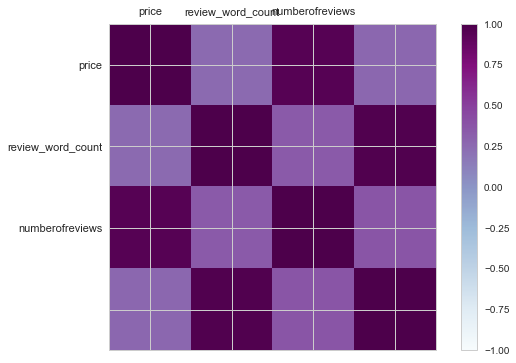

In [263]:
related_columns = ['review_word_count','review_word_count_1',"numberofreviews","numberofreviews_1"]

def CheckingCorrelations(columnnames):
    correlations = df_main[columnnames].corr()
    print(correlations)

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1, cmap='BuPu')
    fig.colorbar(cax)
    ticks = np.arange(0, 4, 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(corrnames)
    ax.set_yticklabels(corrnames)
    ax.tick_params(labelsize=11)
    plt.show()

CheckingCorrelations(related_columns)

                   numberofreviews  numberofreviews_1
numberofreviews           1.000000           0.382779
numberofreviews_1         0.382779           1.000000


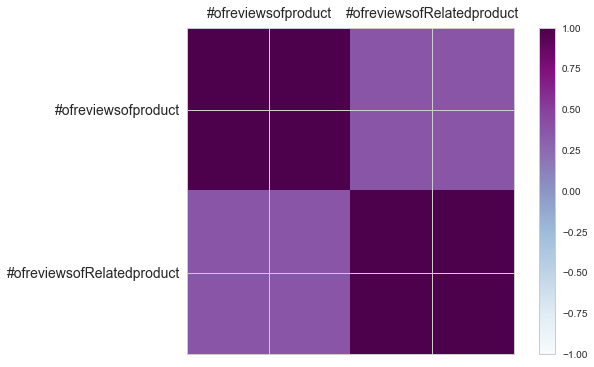

In [264]:
related_columns = ["numberofreviews","numberofreviews_1"]

related_columns_names = ["#ofreviewsofproduct","#ofreviewsofRelatedproduct"]

def CheckingCorrelations(columnnames):
    correlations = df_main[columnnames].corr()
    print(correlations)

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1, cmap='BuPu')
    fig.colorbar(cax)
    ticks = np.arange(0, 2, 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(related_columns_names)
    ax.set_yticklabels(related_columns_names)
    ax.tick_params(labelsize=14)
    plt.show()

CheckingCorrelations(related_columns)